In [51]:
from Bio import SeqIO
from Bio.Seq import Seq
import os
from Bio.Align import PairwiseAligner
import matplotlib.pyplot as plt

In [28]:
# Set the working directory
working_dir = "/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords"
os.chdir(working_dir)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords


In [ ]:
def find_genes_with_sequence(fasta_file, target_sequence):
    target_seq = Seq(target_sequence)
    target_rc = target_seq.reverse_complement()
    
    genes_with_sequence = []

    for record in SeqIO.parse(fasta_file, "fasta"):
        gene_name = record.id
        gene_seq = record.seq
        
        if target_seq in gene_seq or target_rc in gene_seq:
            genes_with_sequence.append(gene_name)

    return genes_with_sequence

def generate_antisense(sequence):
    """Generate the antisense sequence."""
    return str(Seq(sequence).reverse_complement())

In [34]:
def find_genes_with_sequence(fasta_file, target_sequence):
    target_seq = Seq(target_sequence)
    target_rc = target_seq.reverse_complement()
    
    genes_with_sequence = []

    for record in SeqIO.parse(fasta_file, "fasta"):
        gene_name = record.id
        gene_seq = record.seq
        
        if target_seq in gene_seq or target_rc in gene_seq:
            genes_with_sequence.append(gene_name)

    return genes_with_sequence

def generate_antisense(sequence):
    """Generate the antisense sequence."""
    return str(Seq(sequence).reverse_complement())

In [35]:
fasta_file = "DATA/human_cds.fasta"

In [36]:
ASE1 = 'AACATTCCTTGGAAAAG'
ASE2 = 'CGTCATTCTCATCGGAA'

antisense_ASE1 = generate_antisense(ASE1)
print(f"Antisense sequence: {antisense_ASE1}")

antisense_ASE2 = generate_antisense(ASE2)
print(f"Antisense sequence: {antisense_ASE2}")

print(len(antisense_ASE1), len(antisense_ASE2))

Antisense sequence: CTTTTCCAAGGAATGTT
Antisense sequence: TTCCGATGAGAATGACG
17 17


In [37]:
matching_genes_ASE1 = find_genes_with_sequence(fasta_file, antisense_ASE1)
print(f"Genes containing the sequence '{antisense_ASE1}':")

Genes containing the sequence 'CTTTTCCAAGGAATGTT':


In [38]:
matching_genes_ASE2 = find_genes_with_sequence(fasta_file, antisense_ASE2)
print(f"Genes containing the sequence '{antisense_ASE2}':")

Genes containing the sequence 'TTCCGATGAGAATGACG':


In [39]:
# Create a dictionary with genes as keys and sequences as values
gene_sequence_dict = {}
for record in SeqIO.parse(fasta_file, "fasta"):
    gene_name = record.id
    gene_sequence = str(record.seq)
    gene_sequence_dict[gene_name] = gene_sequence

print(f"Number of genes loaded: {len(gene_sequence_dict)}")

Number of genes loaded: 123495


In [45]:
def align_sequence(query, target, allowed_mismatches=1):
    """Perform local alignment and return the best score."""
    aligner = PairwiseAligner()
    aligner.mode = 'local'
    aligner.match_score = 1
    aligner.mismatch_score = -1
    aligner.open_gap_score = -1
    aligner.extend_gap_score = -0.5
    try:
        alignments = aligner.align(query, target)
        best_alignment = max(alignments, key=lambda a: a.score)
        mismatches = sum(1 for q, t in zip(best_alignment.query, best_alignment.target) if q != t)
        if mismatches <= allowed_mismatches:
            return [best_alignment.score, mismatches]
        else:
            return [0, mismatches]
    except OverflowError:
        print(f"OverflowError occurred during alignment. Query length: {len(query)}, Target length: {len(target)}")
        return 0

def check_alignment(antisense_seq, allowed_mismatches, gene_sequences):
    """Check alignment of antisense sequence with the given list of genes."""
    results = []
    mismatches = []
    for gene, gene_seq in gene_sequences.items():
        score = align_sequence(antisense_seq, gene_seq, allowed_mismatches)
        if score[0] == len(antisense_seq):  # match
            results.append(gene)
            mismatches.append([gene, score[1]])
        else:
            mismatches.append([gene, score[1]])
    return [results, mismatches]

In [46]:
aligned_genes_ASE1 = check_alignment(antisense_ASE1, allowed_mismatches=3, gene_sequences=gene_sequence_dict)

In [57]:
gene_scores = aligned_genes_ASE1[1]

In [58]:
import requests
import pandas as pd
from io import StringIO

def download_ensembl_mapping():
    # Ensembl BioMart URL
    url = "http://www.ensembl.org/biomart/martservice"

    # Query parameters
    query = '''<?xml version="1.0" encoding="UTF-8"?>
    <!DOCTYPE Query>
    <Query virtualSchemaName="default" formatter="TSV" header="0" uniqueRows="0" count="" datasetConfigVersion="0.6">
        <Dataset name="hsapiens_gene_ensembl" interface="default">
            <Attribute name="ensembl_transcript_id_version" />
            <Attribute name="external_gene_name" />
        </Dataset>
    </Query>
    '''

    # Send POST request
    response = requests.post(url, data={'query': query})

    # Check if the request was successful
    if response.status_code == 200:
        # Convert the response content to a pandas DataFrame
        df = pd.read_csv(StringIO(response.text), sep='\t', header=None, names=['transcript_id', 'gene_symbol'])
        return df
    else:
        print(f"Error downloading data: Status code {response.status_code}")
        return None

def create_mapping_dict(df):
    return dict(zip(df['transcript_id'], df['gene_symbol']))

In [56]:
# Download the mapping
mapping_df = download_ensembl_mapping()

In [59]:
if mapping_df is not None:
    # Create a dictionary for easy lookup
    mapping_dict = create_mapping_dict(mapping_df)

    # Print the first few entries of the mapping
    print("First few entries of the mapping:")
    for i, (transcript_id, gene_symbol) in enumerate(mapping_dict.items()):
        print(f"{transcript_id} -> {gene_symbol}")
        if i >= 4:  # Print only the first 5 entries
            break
    
    renamed_list = []
    for enst_id, score in gene_scores:
        gene_symbol = mapping_dict.get(enst_id, enst_id)  # Use original ID if not found in mapping
        renamed_list.append([gene_symbol, score])

    print("\nFirst few entries of the renamed list:")
    for entry in renamed_list[:5]:  # Print only the first 5 entries
        print(entry)
else:
    print("Failed to download mapping. Please check your internet connection and try again.")

First few entries of the mapping:
ENST00000387314.1 -> MT-TF
ENST00000389680.2 -> MT-RNR1
ENST00000387342.1 -> MT-TV
ENST00000387347.2 -> MT-RNR2
ENST00000386347.1 -> MT-TL1

First few entries of the renamed list:
['TRDD1', 7]
['TRDD3', 11]
['TRDD2', 4]
['TRBD1', 10]
['TRBD1', 10]


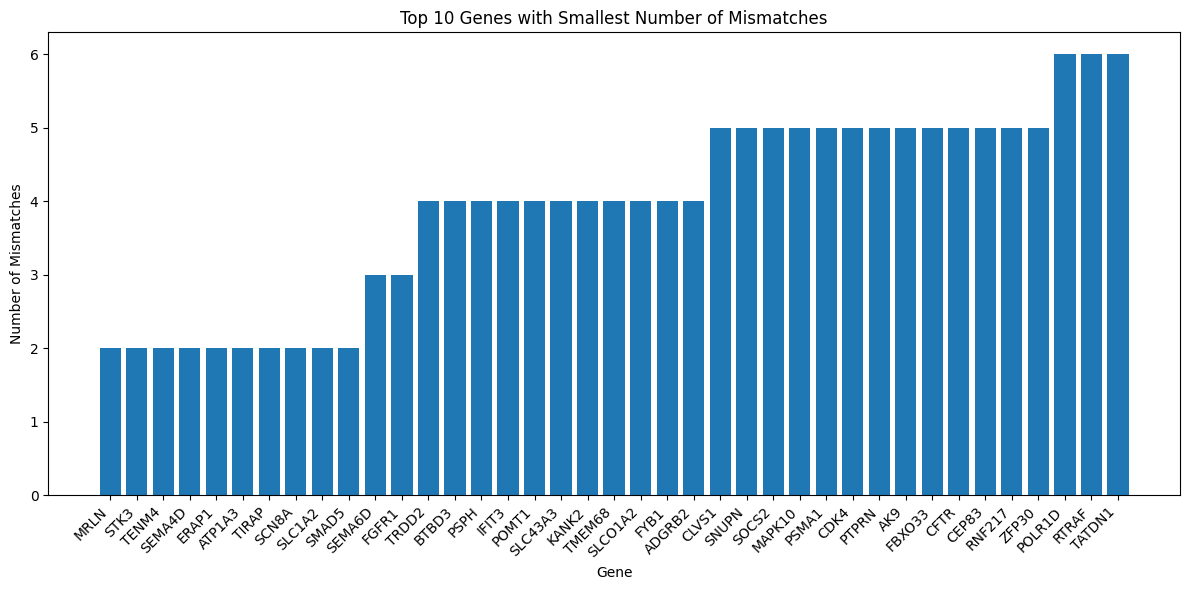

In [65]:
# Sort the mismatches list by the number of mismatches (second element of each sublist)
sorted_gene_scores = sorted(renamed_list, key=lambda x: x[1])
top_10_genes = sorted_gene_scores[:50]

# Create a bar plot
plt.figure(figsize=(12, 6))
genes = [gene[0] for gene in top_10_genes]
mismatches = [gene[1] for gene in top_10_genes]

plt.bar(genes, mismatches)
plt.xlabel('Gene')
plt.ylabel('Number of Mismatches')
plt.title('Top 10 Genes with Smallest Number of Mismatches')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
# Create a bar plot
plt.figure(figsize=(12, 6))
genes = [gene[0] for gene in top_10_genes]
mismatches = [gene[1] for gene in top_10_genes]

plt.bar(genes, mismatches)
plt.xlabel('Gene')
plt.ylabel('Number of Mismatches')
plt.title('Top 10 Genes with Smallest Number of Mismatches')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()